## Get Dataset ##

In [1]:
import glob
from collections import defaultdict
from collections import Counter
import ast
import itertools

In [24]:
fr = open("./lang_games_data.txt", "w")
list_files = glob.glob("./cubeturk/examples/*.lisp")
data = []
pl_id = defaultdict(int)
for file in list_files:
    with open(file,'r') as f:
        context = ""
        sess_id = ""
        target = ""
        utterance = ""
        for line in f:
            if "id session" in line:
                start = 'id session:'
                end = ')'
                sess_id = line[line.find(start)+len(start):line.rfind(end)]
                pl_id[sess_id] += 1
            elif "context (" in line:
                start = 'graph NaiveKnowledgeGraph ((string '
                end = ') (name b)'
                context = line[line.find(start)+len(start):line.rfind(end)]
            elif "(utterance " in line:
                start = '(utterance'
                end = ')'
                utterance = line[line.find(start)+len(start):line.rfind(end)][1:].replace('"','')
            elif "(targetValue" in line:
                start = '(targetValue (string '
                end = '))'
                target = line[line.find(start)+len(start):line.rfind(end)]
            elif line == ")\n":
                fr.write(sess_id + "\t" + context + "\t" + utterance + "\t" + target + "\n")
                context = ""
                sess_id = "",
                target = ""
                utterance = ""
fr.close()

In [6]:
#fr = open("./lang_games_data.txt", "w")
#list_files = glob.glob("./dataset/sida wang's/lisps/*.lisp")
list_files = ["./dataset/sida wang's/lisps/A1HKYY6XI2OHO1.lisp"]
data = []
pl_id = defaultdict(int)
count = 0
for file in list_files:
    start = "./dataset/sida wang's/lisps/"
    end = '.lisp'
    file_name = file[file.find(start)+len(start):file.rfind(end)]
    #fw = open("./dataset/sida wang's/txt/" + file_name + ".txt", "w")
    with open(file,'r') as f:
        context_list = []
        target_list = []
        utterance = ""
        skip = False
        #fw = open("./dataset/sida wang's/*.lisp")
        for line in f:
            if "context (" in line:
                count += 1
                start = 'graph NaiveKnowledgeGraph ((string '
                end = ') (name b)'
                context = line[line.find(start)+len(start):line.rfind(end)]
                counter = Counter(context)
                try:
                    context_list = ast.literal_eval(context)
                except:
                    skip = True
                    continue
#                 len_prev = len(context_list)
#                 for el in context_list:
#                     if len(el) > 3:
#                         skip = True
#                         print(context)
#                 if len_prev >= 7:
#                     skip = True
#                     print(context)
#                 else:
#                 if len_prev < 7:
#                     res_len = 7 - len_prev - 1
#                     for _ in range(res_len):
#                         context_list.append(["X"])
                for i, el in enumerate(context_list):
                    rs = 3 - len(el)
                    for j in range(rs):
                        context_list[i].append("X")
                context_list = list(itertools.chain(*context_list))
                for i in range(1,len_prev):
                    context_list.insert(i*3+i-1,'#')
            elif "(utterance " in line and not skip:
                start = '(utterance'
                end = ')'
                utterance = line[line.find(start)+len(start):line.rfind(end)][1:].replace('"','')
            elif "(targetValue" in line and not skip:
                start = '(targetValue (string '
                end = '))'
                context = line[line.find(start)+len(start):line.rfind(end)]
                counter = Counter(context)
                target_list = ast.literal_eval(context)
                len_prev = len(target_list) 
                
                for el in target_list:
                    if len(el) > 3:
                        skip = True
                if len_prev >= 7:
                    skip = True
                
#                 if len_prev < 7:
#                     res_len = 7 - len_prev - 1
#                     for _ in range(res_len):
#                         target_list.append(["X"])
                        
                for i, el in enumerate(target_list):
                    rs = 3 - len(el)
                    for j in range(rs):
                        target_list[i].append("X")
                len_prev = len(target_list)
                target_list = list(itertools.chain(*target_list))
                for i in range(1,len_prev):
                    target_list.insert(i*3+i-1,'#')
            elif line == ")\n":
                #if not skip:
                    #fw.write(" ".join(str(bc) for bc in context_list)
                    #    + "\t" + utterance + "\t" + " ".join(str(bc) for bc in target_list) + "\n")
                    #print(" ".join(str(bc) for bc in context_list)
                    #    + "\t" + utterance + "\t" + " ".join(str(bc) for bc in target_list))
                context_list = []
                target_list = []
                utterance = ""
                skip = False
    #fw.close()
#             if "id session" in line:
#                 start = 'id session:'
#                 end = ')'
#                 sess_id = line[line.find(start)+len(start):line.rfind(end)]
#                 pl_id[sess_id] += 1
#             elif "context (" in line:
#                 start = 'graph NaiveKnowledgeGraph ((string '
#                 end = ') (name b)'
#                 context = line[line.find(start)+len(start):line.rfind(end)]
#             elif "(utterance " in line:
#                 start = '(utterance'
#                 end = ')'
#                 utterance = line[line.find(start)+len(start):line.rfind(end)][1:].replace('"','')
#             elif "(targetValue" in line:
#                 start = '(targetValue (string '
#                 end = '))'
#                 target = line[line.find(start)+len(start):line.rfind(end)]
#             elif line == ")\n":
#                 fr.write(sess_id + "\t" + context + "\t" + utterance + "\t" + target + "\n")
#                 context = ""
#                 sess_id = "",
#                 target = ""
#                 utterance = ""
# fr.close()
print(count)

[[3],[2],[2],[1],[3],[2],[3]]
[[2],[3],[1],[2],[1],[0],[3]]
[[0],[0],[2],[1],[1],[0],[0]]
[[2,2],[2,0,0,0],[2,0,0,0],[2,0,0],[2,2]]
[[2,2],[2,0,0,0],[2,0,0,0],[2,0,0],[2,2]]
[[2,2],[2,0,0],[2,0,0,0],[2,0,0],[2,2]]
63


## Generate Dataset ##

In [1]:
from random import randint
import random
import copy
import itertools

In [2]:
# we assume that there are 6 tiles and maximum 3 blocks
color_blocks = ["0", "1", "2", "3"] # cyan, brown, red, orange
color_strings = ["cyan", "brown", "red", "orange"]
operation = ["remove", "add"]
positional_info = ["1st", "2nd", "3rd", "4th", "5th", "6th", "even", "odd", "leftmost", "rightmost", "every"]
num_tiles, max_block, num_color = 6, 3, 3

In [14]:
def generate_train_data(num_tiles, max_block, num_color, opr, added_set):
    match = False
    ## user command ##
    #opr = random.choice(operation)
    clr = random.choice(color_strings)
    pos = random.choice(positional_info)
    if opr == "remove": 
        info = " at "
    else:
        info = " to "
    command = opr + " " +  clr + info + pos + " tile"
    #command = "remove cyan at 1st tile"
    
    ## initial state ##
    already_added = True
    while already_added:
        block_config = []
        for i in range(num_tiles): # loop through all the tiles
            num_blocks = randint(0,max_block)
            if num_blocks == 0:
                block_config.append([])
            else:
                blocks = []
                for j in range(num_blocks):
                    block_color_idx = randint(0,num_color)
                    blocks.append(color_blocks[block_color_idx])
                block_config.append(blocks)
        if str(block_config) not in added_set:
            already_added = False
            
    ## generate next state ##
    next_block_config =  copy.deepcopy(block_config)
    tile_indexs = [-1]
    if "1" in command or "leftmost" in command:
        tile_indexs = [0]
    elif "2" in command:
        tile_indexs = [1]
    elif "3" in command:
        tile_indexs = [2]
    elif "4" in command:
        tile_indexs = [3]
    elif "5" in command:
        tile_indexs = [4]
    elif "6" in command or "rightmost" in command:
        tile_indexs = [5]
    elif "even" in command:
        tile_indexs = [1,3,5]
    elif "odd" in command:
        tile_indexs = [0,2,4]
    elif "every" in command:
        tile_indexs = [0,1,2,3,4,5]
        
    for tile_index in tile_indexs:
        if "remove" in command:
            if len(next_block_config[tile_index]) != 0:
                if "cyan" in command:
                    if next_block_config[tile_index][-1] == "0":
                        next_block_config[tile_index].pop()
                        match = True
                elif "brown" in command:
                    if next_block_config[tile_index][-1] == "1":
                        next_block_config[tile_index].pop()
                        match = True
                elif "red" in command:
                    if next_block_config[tile_index][-1] == "2":
                        next_block_config[tile_index].pop()
                        match = True
                elif "orange" in command:
                    if next_block_config[tile_index][-1] == "3":
                        next_block_config[tile_index].pop()
                        match = True
        elif "add" in command and len(next_block_config[tile_index]) < 3:
            if "cyan" in command:
                next_block_config[tile_index].append("0")
                match = True
            elif "brown" in command:
                next_block_config[tile_index].append("1")
                match = True
            elif "red" in command:
                next_block_config[tile_index].append("2")
                match = True
            elif "orange" in command:
                next_block_config[tile_index].append("3")
                match = True
    if match:
        added_set.add(str(block_config))
        
    # change block_config
    for i, el in enumerate(block_config):
        rs = 3 - len(el)
        for j in range(rs):
            block_config[i].append("X")
    block_config = list(itertools.chain(*block_config))
    for i in range(1,6):
        block_config.insert(i*3+i-1,'#')
    
    for i, el in enumerate(next_block_config):
        rs = 3 - len(el)
        for j in range(rs):
            next_block_config[i].append("X")
    next_block_config = list(itertools.chain(*next_block_config))
    for i in range(1,6):
        next_block_config.insert(i*3+i-1,'#')
            
    return block_config, command, next_block_config, match, added_set

In [4]:
total = 20000

f = open("./lang_games_data_artificial_train_nvl_state_" + str(total) + ".txt", "w")
ft = open("./lang_games_data_artificial_test_nvl_state_" + str(total) + ".txt", "w")
added_set = set()

half = 0.5 * total
train_composition = 0.8 * half
for i in range(total):
    opr = "add"
    if i < half:
        opr = "remove"
    match = False

    while not match:
        block_config, command, next_block_config, match, added_set = generate_train_data(
            num_tiles, max_block, num_color, opr, added_set)
        if match:
            if (i >= train_composition and i <half) or (i >= (train_composition + half) and i < total):
                ft.write(" ".join(bc for bc in block_config) 
                        + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
            else:
                f.write(" ".join(bc for bc in block_config) 
                        + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
f.close()
ft.close()

## General Command

In [12]:
def generate_train_data_novel(num_tiles, max_block, num_color, opr, blocks_b, utter_b, 
                              added_set, blocks, command_set):
    match = False    
    ## user command ##
    if utter_b:
        command = random.choice(command_set)
    else:
        opr = random.choice(operation)
        clr = random.choice(color_strings)
        pos = random.choice(positional_info)
        if opr == "remove": 
            info = " at "
        else:
            info = " to "
        command = opr + " " +  clr + info + pos + " tile"
    
    ## initial state ##
    already_added = True
    if blocks_b:
        while already_added:
            block_config = []
            block_cfg = random.sample(blocks, num_tiles)
            for i in range(num_tiles): # loop through all the tiles
                x = list(block_cfg[i])
                x = list(filter(lambda a: a != 'X', x))
                block_config.append(x)
            if str(block_config) not in added_set:
                already_added = False
    else:
        while already_added:
            block_config = []
            for i in range(num_tiles): # loop through all the tiles
                num_blocks = randint(0,max_block)
                if num_blocks == 0:
                    block_config.append([])
                else:
                    blocks = []
                    for j in range(num_blocks):
                        block_color_idx = randint(0,num_color)
                        blocks.append(color_blocks[block_color_idx])
                    block_config.append(blocks)
            if str(block_config) not in added_set:
                already_added = False
    ## generate next state ##
    next_block_config =  copy.deepcopy(block_config)
    tile_indexs = [-1]
    if "1" in command or "leftmost" in command:
        tile_indexs = [0]
    elif "2" in command:
        tile_indexs = [1]
    elif "3" in command:
        tile_indexs = [2]
    elif "4" in command:
        tile_indexs = [3]
    elif "5" in command:
        tile_indexs = [4]
    elif "6" in command or "rightmost" in command:
        tile_indexs = [5]
    elif "even" in command:
        tile_indexs = [1,3,5]
    elif "odd" in command:
        tile_indexs = [0,2,4]
    elif "every" in command:
        tile_indexs = [0,1,2,3,4,5]
        
    for tile_index in tile_indexs:
        if "remove" in command:
            if len(next_block_config[tile_index]) != 0:
                if "cyan" in command:
                    if next_block_config[tile_index][-1] == "0":
                        next_block_config[tile_index].pop()
                        match = True
                elif "brown" in command:
                    if next_block_config[tile_index][-1] == "1":
                        next_block_config[tile_index].pop()
                        match = True
                elif "red" in command:
                    if next_block_config[tile_index][-1] == "2":
                        next_block_config[tile_index].pop()
                        match = True
                elif "orange" in command:
                    if next_block_config[tile_index][-1] == "3":
                        next_block_config[tile_index].pop()
                        match = True
        elif "add" in command and len(next_block_config[tile_index]) < 3:
            if "cyan" in command:
                next_block_config[tile_index].append("0")
                match = True
            elif "brown" in command:
                next_block_config[tile_index].append("1")
                match = True
            elif "red" in command:
                next_block_config[tile_index].append("2")
                match = True
            elif "orange" in command:
                next_block_config[tile_index].append("3")
                match = True
    if match:
        added_set.add(str(block_config))
        
    # change block_config
    for i, el in enumerate(block_config):
        rs = 3 - len(el)
        for j in range(rs):
            block_config[i].append("X")
    block_config = list(itertools.chain(*block_config))
    for i in range(1,6):
        block_config.insert(i*3+i-1,'#')
    
    for i, el in enumerate(next_block_config):
        rs = 3 - len(el)
        for j in range(rs):
            next_block_config[i].append("X")
    next_block_config = list(itertools.chain(*next_block_config))
    for i in range(1,6):
        next_block_config.insert(i*3+i-1,'#')
            
    return block_config, command, next_block_config, match, added_set

## Generate Novel Dataset - Blocks

In [10]:
alphabet = ["0","1","2","3","X"]
novel_amount = 15
blocks = [''.join(p) for p in itertools.product(alphabet, repeat=3)]
blocks_n = []
for bl in blocks:
    if 'X' in bl[1] and bl[2] is not 'X':
        blocks_n.append(bl)
    elif 'X' in bl[0] and bl[1] is not 'X':
        blocks_n.append(bl)
# length : 85
blocks_fin = [x for x in blocks if x not in blocks_n]
#blocks = list(itertools.chain(*(itertools.permutations(alphabet, i) for i in range(3,3+1))))
#blocks = list(map(lambda x:"".join(x), blocks))
blocks_test = random.sample(blocks_fin, novel_amount)
blocks_mt = [x for x in blocks_fin if x not in blocks_test]
blocks_valid = random.sample(blocks_mt, novel_amount)
blocks = [x for x in blocks_mt if x not in blocks_valid]

In [6]:
def generate_train_data_novel(num_tiles, max_block, num_color, opr, added_set, blocks):
    match = False
    ## user command ##
    #opr = random.choice(operation)
    clr = random.choice(color_strings)
    pos = random.choice(positional_info)
    if opr == "remove": 
        info = " at "
    else:
        info = " to "
    command = opr + " " +  clr + info + pos + " tile"
    #command = "remove cyan at 1st tile"
    
    ## initial state ##
    already_added = True
    while already_added:
        block_config = []
        block_cfg = random.sample(blocks, num_tiles)
        for i in range(num_tiles): # loop through all the tiles
            x = list(block_cfg[i])
            x = list(filter(lambda a: a != 'X', x))
            block_config.append(x)
        if str(block_config) not in added_set:
            already_added = False
            
    ## generate next state ##
    next_block_config =  copy.deepcopy(block_config)
    tile_indexs = [-1]
    if "1" in command or "leftmost" in command:
        tile_indexs = [0]
    elif "2" in command:
        tile_indexs = [1]
    elif "3" in command:
        tile_indexs = [2]
    elif "4" in command:
        tile_indexs = [3]
    elif "5" in command:
        tile_indexs = [4]
    elif "6" in command or "rightmost" in command:
        tile_indexs = [5]
    elif "even" in command:
        tile_indexs = [1,3,5]
    elif "odd" in command:
        tile_indexs = [0,2,4]
    elif "every" in command:
        tile_indexs = [0,1,2,3,4,5]
        
    for tile_index in tile_indexs:
        if "remove" in command:
            if len(next_block_config[tile_index]) != 0:
                if "cyan" in command:
                    if next_block_config[tile_index][-1] == "0":
                        next_block_config[tile_index].pop()
                        match = True
                elif "brown" in command:
                    if next_block_config[tile_index][-1] == "1":
                        next_block_config[tile_index].pop()
                        match = True
                elif "red" in command:
                    if next_block_config[tile_index][-1] == "2":
                        next_block_config[tile_index].pop()
                        match = True
                elif "orange" in command:
                    if next_block_config[tile_index][-1] == "3":
                        next_block_config[tile_index].pop()
                        match = True
        elif "add" in command and len(next_block_config[tile_index]) < 3:
            if "cyan" in command:
                next_block_config[tile_index].append("0")
                match = True
            elif "brown" in command:
                next_block_config[tile_index].append("1")
                match = True
            elif "red" in command:
                next_block_config[tile_index].append("2")
                match = True
            elif "orange" in command:
                next_block_config[tile_index].append("3")
                match = True
    if match:
        added_set.add(str(block_config))
        
    # change block_config
    for i, el in enumerate(block_config):
        rs = 3 - len(el)
        for j in range(rs):
            block_config[i].append("X")
    block_config = list(itertools.chain(*block_config))
    for i in range(1,6):
        block_config.insert(i*3+i-1,'#')
    
    for i, el in enumerate(next_block_config):
        rs = 3 - len(el)
        for j in range(rs):
            next_block_config[i].append("X")
    next_block_config = list(itertools.chain(*next_block_config))
    for i in range(1,6):
        next_block_config.insert(i*3+i-1,'#')
        
    return block_config, command, next_block_config, match, added_set

In [13]:
total_train = 16000
total_test = 4000
total_valid = 4000
total = total_train + total_test + total_valid

f = open("./lang_games_data_artificial_train_nvl_blocks_" + str(total) + ".txt", "w")
ft = open("./lang_games_data_artificial_test_nvl_blocks_" + str(total) + ".txt", "w")
fv = open("./lang_games_data_artificial_valid_nvl_blocks_" + str(total) + ".txt", "w")
added_set = set()

for i in range(total_train):
    opr = "add"
    if i < 0.5 * total_train:
        opr = "remove"
    match = False

    while not match:
        if i < 0.5 * total_train:
            block_config, command, next_block_config, match, added_set = generate_train_data_novel(
                num_tiles, max_block, num_color, opr, True, False, added_set, blocks, set())
            if match:
                f.write(" ".join(bc for bc in block_config) 
                         + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
        else:
            block_config, command, next_block_config, match, added_set = generate_train_data_novel(
                num_tiles, max_block, num_color, opr, True, False, added_set, blocks, set())
            if match:
                f.write(" ".join(bc for bc in block_config) 
                        + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
f.close()

for i in range(total_test):
    opr = "add"
    if i < 0.5 * total_test:
        opr = "remove"
    match = False

    while not match:
        if i < 0.5 * total_test:
            block_config, command, next_block_config, match, added_set = generate_train_data_novel(
                num_tiles, max_block, num_color, opr, True, False, added_set, blocks_test, set())
            if match:
                ft.write(" ".join(bc for bc in block_config) 
                         + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
        else:
            block_config, command, next_block_config, match, added_set = generate_train_data_novel(
                num_tiles, max_block, num_color, opr, True, False, added_set, blocks_test, set())
            if match:
                ft.write(" ".join(bc for bc in block_config) 
                        + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
ft.close()

for i in range(total_valid):
    opr = "add"
    if i < 0.5 * total_valid:
        opr = "remove"
    match = False

    while not match:
        if i < 0.5 * total_test:
            block_config, command, next_block_config, match, added_set = generate_train_data_novel(
                num_tiles, max_block, num_color, opr, True, False, added_set, blocks_valid, set())
            if match:
                fv.write(" ".join(bc for bc in block_config) 
                         + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
        else:
            block_config, command, next_block_config, match, added_set = generate_train_data_novel(
                num_tiles, max_block, num_color, opr, True, False, added_set, blocks_valid, set())
            if match:
                fv.write(" ".join(bc for bc in block_config) 
                        + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
fv.close()

## Generate Novel Dataset - Utterance

In [4]:
def add_info(string):
    ins = string.split(" ")
    ins.insert(3, "tile")
    if ins[0] == "remove":
        ins.insert(2, "at")
    elif ins[0] == "add":
        ins.insert(2, "to")
    return " ".join(ins)
command_list = [["remove", "add"],["cyan", "brown", "red", "orange"],["1st", "2nd", "3rd", "4th", "5th", "6th", "even", "odd", "leftmost", "rightmost", "every"]]
# length : 88
novel_amount = 10
command = [add_info(" ".join(p)) for p in itertools.product(*command_list)]
r_command = command[:44]
a_command = command[44:]
rmv_test = random.sample(r_command, novel_amount)
add_test = random.sample(a_command, novel_amount)
add_command = [x for x in a_command if x not in add_test]
rmv_command = [x for x in r_command if x not in rmv_test]
#command_fin = [add_info(val) for pair in zip(add_command, rmv_command) for val in pair]
#command_fin_test = [add_info(val) for pair in zip(add_test, rmv_test) for val in pair]

In [114]:
def generate_train_data_utter(num_tiles, max_block, num_color, opr, added_set, command_set):
    match = False
    ## user command ##
    #opr = random.choice(operation)
#     clr = random.choice(color_strings)
#     pos = random.choice(positional_info)
#     if opr == "remove": 
#         info = " at "
#     else:
#         info = " to "
#     command = opr + " " +  clr + info + pos + " tile"
    #command = "remove cyan at 1st tile"
    command = random.choice(command_set)
    
    ## initial state ##
    already_added = True
    while already_added:
        block_config = []
        for i in range(num_tiles): # loop through all the tiles
            num_blocks = randint(0,max_block)
            if num_blocks == 0:
                block_config.append([])
            else:
                blocks = []
                for j in range(num_blocks):
                    block_color_idx = randint(0,num_color)
                    blocks.append(color_blocks[block_color_idx])
                block_config.append(blocks)
        if str(block_config) not in added_set:
            already_added = False
            
    ## generate next state ##
    next_block_config =  copy.deepcopy(block_config)
    tile_indexs = [-1]
    if "1" in command or "leftmost" in command:
        tile_indexs = [0]
    elif "2" in command:
        tile_indexs = [1]
    elif "3" in command:
        tile_indexs = [2]
    elif "4" in command:
        tile_indexs = [3]
    elif "5" in command:
        tile_indexs = [4]
    elif "6" in command or "rightmost" in command:
        tile_indexs = [5]
    elif "even" in command:
        tile_indexs = [1,3,5]
    elif "odd" in command:
        tile_indexs = [0,2,4]
    elif "every" in command:
        tile_indexs = [0,1,2,3,4,5]
        
    for tile_index in tile_indexs:
        if "remove" in command:
            if len(next_block_config[tile_index]) != 0:
                if "cyan" in command:
                    if next_block_config[tile_index][-1] == "0":
                        next_block_config[tile_index].pop()
                        match = True
                elif "brown" in command:
                    if next_block_config[tile_index][-1] == "1":
                        next_block_config[tile_index].pop()
                        match = True
                elif "red" in command:
                    if next_block_config[tile_index][-1] == "2":
                        next_block_config[tile_index].pop()
                        match = True
                elif "orange" in command:
                    if next_block_config[tile_index][-1] == "3":
                        next_block_config[tile_index].pop()
                        match = True
        elif "add" in command and len(next_block_config[tile_index]) < 3:
            if "cyan" in command:
                next_block_config[tile_index].append("0")
                match = True
            elif "brown" in command:
                next_block_config[tile_index].append("1")
                match = True
            elif "red" in command:
                next_block_config[tile_index].append("2")
                match = True
            elif "orange" in command:
                next_block_config[tile_index].append("3")
                match = True
    if match:
        added_set.add(str(block_config))
        
    # change block_config
    for i, el in enumerate(block_config):
        rs = 3 - len(el)
        for j in range(rs):
            block_config[i].append("X")
    block_config = list(itertools.chain(*block_config))
    for i in range(1,6):
        block_config.insert(i*3+i-1,'#')
    
    for i, el in enumerate(next_block_config):
        rs = 3 - len(el)
        for j in range(rs):
            next_block_config[i].append("X")
    next_block_config = list(itertools.chain(*next_block_config))
    for i in range(1,6):
        next_block_config.insert(i*3+i-1,'#')
            
    return block_config, command, next_block_config, match, added_set

In [115]:
total_train = 16000
total_test = 4000
total = total_train + total_test

f = open("./lang_games_data_artificial_train_nvl_utter_" + str(total) + ".txt", "w")
ft = open("./lang_games_data_artificial_test_nvl_utter_" + str(total) + ".txt", "w")
added_set = set()

for i in range(total_train):
    opr = "add"
    if i < 0.5 * total_train:
        opr = "remove"
    match = False

    while not match:
        if i < 0.5 * total_train:
            block_config, command, next_block_config, match, added_set = generate_train_data_utter(
                num_tiles, max_block, num_color, opr, added_set, rmv_command)
            if match:
                f.write(" ".join(bc for bc in block_config) 
                         + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
        else:
            block_config, command, next_block_config, match, added_set = generate_train_data_utter(
                num_tiles, max_block, num_color, opr, added_set, add_command)
            if match:
                f.write(" ".join(bc for bc in block_config) 
                        + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
f.close()

for i in range(total_test):
    opr = "add"
    if i < 0.5 * total_test:
        opr = "remove"
    match = False

    while not match:
        if i < 0.5 * total_test:
            block_config, command, next_block_config, match, added_set = generate_train_data_utter(
                num_tiles, max_block, num_color, opr, added_set, rmv_test)
            if match:
                ft.write(" ".join(bc for bc in block_config) 
                         + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
        else:
            block_config, command, next_block_config, match, added_set = generate_train_data_utter(
                num_tiles, max_block, num_color, opr, added_set, add_test)
            if match:
                ft.write(" ".join(bc for bc in block_config) 
                        + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
ft.close()

## Generate Novel Dataset - Blocks and Utterance

In [116]:
def generate_train_data_utter(num_tiles, max_block, num_color, opr, added_set, blocks, command_set):
    match = False
    ## user command ##
    #opr = random.choice(operation)
#     clr = random.choice(color_strings)
#     pos = random.choice(positional_info)
#     if opr == "remove": 
#         info = " at "
#     else:
#         info = " to "
#     command = opr + " " +  clr + info + pos + " tile"
    #command = "remove cyan at 1st tile"
    command = random.choice(command_set)
    
    ## initial state ##
    already_added = True
    while already_added:
        block_config = []
        block_cfg = random.sample(blocks, num_tiles)
        for i in range(num_tiles): # loop through all the tiles
            x = list(block_cfg[i])
            x = list(filter(lambda a: a != 'X', x))
            block_config.append(x)
        if str(block_config) not in added_set:
            already_added = False
            
    ## generate next state ##
    next_block_config =  copy.deepcopy(block_config)
    tile_indexs = [-1]
    if "1" in command or "leftmost" in command:
        tile_indexs = [0]
    elif "2" in command:
        tile_indexs = [1]
    elif "3" in command:
        tile_indexs = [2]
    elif "4" in command:
        tile_indexs = [3]
    elif "5" in command:
        tile_indexs = [4]
    elif "6" in command or "rightmost" in command:
        tile_indexs = [5]
    elif "even" in command:
        tile_indexs = [1,3,5]
    elif "odd" in command:
        tile_indexs = [0,2,4]
    elif "every" in command:
        tile_indexs = [0,1,2,3,4,5]
        
    for tile_index in tile_indexs:
        if "remove" in command:
            if len(next_block_config[tile_index]) != 0:
                if "cyan" in command:
                    if next_block_config[tile_index][-1] == "0":
                        next_block_config[tile_index].pop()
                        match = True
                elif "brown" in command:
                    if next_block_config[tile_index][-1] == "1":
                        next_block_config[tile_index].pop()
                        match = True
                elif "red" in command:
                    if next_block_config[tile_index][-1] == "2":
                        next_block_config[tile_index].pop()
                        match = True
                elif "orange" in command:
                    if next_block_config[tile_index][-1] == "3":
                        next_block_config[tile_index].pop()
                        match = True
        elif "add" in command and len(next_block_config[tile_index]) < 3:
            if "cyan" in command:
                next_block_config[tile_index].append("0")
                match = True
            elif "brown" in command:
                next_block_config[tile_index].append("1")
                match = True
            elif "red" in command:
                next_block_config[tile_index].append("2")
                match = True
            elif "orange" in command:
                next_block_config[tile_index].append("3")
                match = True
    if match:
        added_set.add(str(block_config))
        
    # change block_config
    for i, el in enumerate(block_config):
        rs = 3 - len(el)
        for j in range(rs):
            block_config[i].append("X")
    block_config = list(itertools.chain(*block_config))
    for i in range(1,6):
        block_config.insert(i*3+i-1,'#')
    
    for i, el in enumerate(next_block_config):
        rs = 3 - len(el)
        for j in range(rs):
            next_block_config[i].append("X")
    next_block_config = list(itertools.chain(*next_block_config))
    for i in range(1,6):
        next_block_config.insert(i*3+i-1,'#')
            
    return block_config, command, next_block_config, match, added_set

In [117]:
total_train = 16000
total_test = 4000
total = total_train + total_test

f = open("./lang_games_data_artificial_train_nvl_utter&blocks_" + str(total) + ".txt", "w")
ft = open("./lang_games_data_artificial_test_nvl_utter&blocks_" + str(total) + ".txt", "w")
added_set = set()

for i in range(total_train):
    opr = "add"
    if i < 0.5 * total_train:
        opr = "remove"
    match = False

    while not match:
        if i < 0.5 * total_train:
            block_config, command, next_block_config, match, added_set = generate_train_data_utter(
                num_tiles, max_block, num_color, opr, added_set, blocks, rmv_command)
            if match:
                f.write(" ".join(bc for bc in block_config) 
                         + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
        else:
            block_config, command, next_block_config, match, added_set = generate_train_data_utter(
                num_tiles, max_block, num_color, opr, added_set, blocks, add_command)
            if match:
                f.write(" ".join(bc for bc in block_config) 
                        + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
f.close()

for i in range(total_test):
    opr = "add"
    if i < 0.5 * total_test:
        opr = "remove"
    match = False

    while not match:
        if i < 0.5 * total_test:
            block_config, command, next_block_config, match, added_set = generate_train_data_utter(
                num_tiles, max_block, num_color, opr, added_set, blocks_test, rmv_test)
            if match:
                ft.write(" ".join(bc for bc in block_config) 
                         + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
        else:
            block_config, command, next_block_config, match, added_set = generate_train_data_utter(
                num_tiles, max_block, num_color, opr, added_set, blocks_test, add_test)
            if match:
                ft.write(" ".join(bc for bc in block_config) 
                        + "\t" + command + "\t" + " ".join(bc for bc in next_block_config) + "\n")
ft.close()

## Convert Dataset

In [2]:
import datetime
import numpy as np
import random
import itertools

In [3]:
def randomize_data(inps):
    remove_ind = np.arange(0, int(0.5 * len(inps)),1)
    add_ind = np.arange(int(0.5 * len(inps)) ,len(inps),1)
    random.shuffle(remove_ind)
    random.shuffle(add_ind)
    shuffled_index = np.array([val for pair in zip(remove_ind, add_ind) for val in pair])
    return np.array(inps)[shuffled_index].tolist()

In [4]:
def get_replaced_data(inps, color):
    res = []
    for a in inps:
        cnt = 0
        for col in color:
            if col in a:
                cnt += 1
        #if cnt == len(color):
        if cnt > 0:
            res.append(a)
    return res

In [5]:
color = ["remove"]
inps = []
with open("./dataset/lang_games_data_artificial_train_nvl_utter_blocks_50000.txt", "r") as f:
    for line in f:
        inps.append(line)
inps = randomize_data(inps)

In [26]:
f = open("./dataset/test_nvl_utter_blocks-remove.lisp", "w")
now = str(datetime.datetime.now())
for line in inps:
    target_blocks = []
    init_blocks = []
    ar = line.split("\t")
    i_blx = ar[0].replace("#","").replace(" ","").replace("\n","")
    t_blx = ar[2].replace("#","").replace(" ","").replace("\n","")
    start = 0
    for i in range(6):
        s_inner_block = []
        inner_block = []
        for j in range(3):
            if t_blx[start+j] != "X":
                inner_block.append(int(t_blx[start+j]))
            if i_blx[start+j] != "X":
                s_inner_block.append(int(i_blx[start+j]))
        start+=3
        target_blocks.append(inner_block)
        init_blocks.append(s_inner_block)
    strings = """(example\n  (id session:rezkatrial)
(context (date 2018 3 01) (graph NaiveKnowledgeGraph ((string """ + str(init_blocks).replace(" ","") + """) (name b) (name c))))
(timeStamp """ + now + """)\n  (NBestInd 0)\n  (utterance """ + '"' + ar[1] + '"' + """)\n  (targetFormula a)
(targetValue (string """ + str(target_blocks).replace(" ","") + """))\n)\n"""
    f.write(strings)
f.close()
#   (context (date 2016 1 29) (graph NaiveKnowledgeGraph ((string [[1,1],[1,3],[1,1],[1,3],[1,1],[1,3]]) (name b) (name c))))
#   (timeStamp 2016-02-29T12:41:54.832)
#   (NBestInd 0)
#   (utterance "remove orange")
#   (targetFormula
#     (call
#       edu.stanford.nlp.sempre.cubeworld.StacksWorld.wallToString
#       (call context:edu.stanford.nlp.sempre.cubeworld.StacksWorld.removeTop (call context:edu.stanford.nlp.sempre.cubeworld.StacksWorld.getTopColor (number 3 COLOR)))
#     )
#   )
#   (targetValue (string [[1,1],[1],[1,1],[1],[1,1],[1]]))
# )"

In [9]:
conf = [[["add", "red"], ["add", "orange"], ["add", "cyan"], ["add", "brown"]], ["test", "valid"]]
config = list(itertools.product(*conf))
print(config)
replace = {}
replace["remove"] = "rmv"
replace["add"] = "et"
replace["3rd"] = "3"
replace["every"] = "evr"
replace["brown"] = "braun"
replace["orange"] = "oranje"
replace["red"] = "roze"
replace["cyan"] = "cyaan"

[(['add', 'red'], 'test'), (['add', 'red'], 'valid'), (['add', 'orange'], 'test'), (['add', 'orange'], 'valid'), (['add', 'cyan'], 'test'), (['add', 'cyan'], 'valid'), (['add', 'brown'], 'test'), (['add', 'brown'], 'valid')]


In [42]:
list_files = glob.glob("./dataset/online_test/*.txt")
for line in list_files:
    start = './dataset/online_test/'
    end = ''
    fname = line[line.find(start)+len(start):line.rfind(end)]
    print(fname)

remove_brown_2nd.txt
cyan_4th.txt
remove_cyan.txt
cyan.txt
remove_cyan_6th.txt
remove_brown_4th.txt
remove_6th.txt
6th.txt
remove_brown_odd.txt
brown_every.txt
brown_6th.txt
brown.txt
remove_odd.txt
cyan_2nd.txt
all.txt
brown_4th.txt
remove_2nd.txt
remove_cyan_every.txt
remove_cyan_odd.txt
2nd.txt
remove_brown_every.txt
cyan_every.txt
every.txt
remove_brown.txt
cyan_6th.txt
remove_every.txt
cyan_odd.txt
4th.txt
brown_odd.txt
remove_cyan_4th.txt
remove_cyan_2nd.txt
remove_4th.txt
brown_2nd.txt
remove.txt
remove_brown_6th.txt


In [17]:
combine = False
for elem in list_files:
    inps = []
    with open(elem, "r") as f:
        for line in f:
            inps.append(line)
    if combine:
        inps_big = []
        with open("./dataset/lang_games_data_artificial_train_nvl_utter_blocks_50000.txt", "r") as f:
            for line in f:
                inps_big.append(line)
        fin_inps = inps_big + inps
    else:
        fin_inps = inps
    start = './dataset/online_test/'
    end = '.txt'
    fname = elem[elem.find(start)+len(start):elem.rfind(end)]
    f = open("./dataset/online_test/lisps/" + fname + "_sing.lisp", "w")
    now = str(datetime.datetime.now())
    for line in fin_inps:
        target_blocks = []
        init_blocks = []
        ar = line.split("\t")
        i_blx = ar[0].replace("#","").replace(" ","").replace("\n","")
        t_blx = ar[2].replace("#","").replace(" ","").replace("\n","")
#         for el in elem[0]:
#             uttr = ar[1].replace(el,replace[el])
        uttr = ar[1]
        start = 0
        for i in range(6):
            s_inner_block = []
            inner_block = []
            for j in range(3):
                if t_blx[start+j] != "X":
                    inner_block.append(int(t_blx[start+j]))
                if i_blx[start+j] != "X":
                    s_inner_block.append(int(i_blx[start+j]))
            start+=3
            target_blocks.append(inner_block)
            init_blocks.append(s_inner_block)
        strings = """(example\n  (id session:rezkatrial)
    (context (date 2018 3 01) (graph NaiveKnowledgeGraph ((string """ + str(init_blocks).replace(" ","") + """) (name b) (name c))))
    (timeStamp """ + now + """)\n  (NBestInd 0)\n  (utterance """ + '"' + uttr + '"' + """)\n  (targetFormula a)
    (targetValue (string """ + str(target_blocks).replace(" ","") + """))\n)\n"""
        f.write(strings)
    f.close()
    print(fname + "_sing")

remove_brown_2nd_sing
cyan_4th_sing
remove_cyan_sing
cyan_sing
remove_cyan_6th_sing
remove_brown_4th_sing
remove_6th_sing
6th_sing
remove_brown_odd_sing
brown_every_sing
brown_6th_sing
brown_sing
remove_odd_sing
cyan_2nd_sing
all_sing
brown_4th_sing
remove_2nd_sing
remove_cyan_every_sing
remove_cyan_odd_sing
2nd_sing
remove_brown_every_sing
cyan_every_sing
every_sing
remove_brown_sing
cyan_6th_sing
remove_every_sing
cyan_odd_sing
4th_sing
brown_odd_sing
remove_cyan_4th_sing
remove_cyan_2nd_sing
remove_4th_sing
brown_2nd_sing
remove_sing
remove_brown_6th_sing


In [6]:
vocab = ["remove", "add", "at", "tile", "1st", "2nd", "3rd", "4th", "5th", "6th", "leftmost", "rightmost", "red",
        "cyan", "orange", "brown", "every", "even", "odd"]
cor_files = []
with open("dataset/sida wang's/out.txt") as f:
    for line in f:
        cor_files.append(line.replace("\n",""))
for el in cor_files:
    overlap_count = 0
    try:
        with open("dataset/sida wang's/txt/" + el + ".txt") as ff:
            for line in ff:
                ar = line.split("\t")
                words = ar[1].split(" ")
                for word in words:
                    if word in vocab:
                        overlap_count += 1
            print(el, overlap_count)
    except:
        print(el, "not found")

0ECjYvl 48
1QPlUN8OJhM 2
2DdHNZKv5mM 99
81YlekTDMbQ 102
830kXNICuqb 0
8cEr4KwXjP9 2
8mtUgG0g0mz 60
8ZXjdVvTjga 70
A10G57EYF3HK46 0
A1123Z7CQMJ05R 0
A11NPNK8885N99 0
A1219SY7CR1UWP 0
A12VSA5C02M3FT 0
A13FF3UBS35JD7 0
A153FVJRRM27G7 2
A154X03NKVZZL1 0
A15781PHGW377Y 0
A15JP0TGZKLNIZ 0
A177EXELDLWTWV 0
A17AMTRIYI2Z2D 98
A17ELSQUMU0QT6 17
A1945USNZHTROX 30
A19ED8FYO6CA36 0
A19V9DLZS91SDL 65
A19XAU8SBQZLYM 49
A1A3TGZ7DKJWRW 99
A1BHHRSKO2MBT3 0
A1BI3WXOR5CTHQ 0
A1BWS5AD2T4NIR 12
A1C6BL1O5L5LA9 0
A1EAEZ7VIHKQ2 0
A1EITLFAMKA61U 13
A1F3TWJXGO0URG 0
A1F669OTXWIJW0 119
A1FBBY2JJYRMRI 93
A1FLNAFLLO3UPK 6
A1FP3SH704X01V 5
A1GQTXZPHAMLEH 4
A1GXFMAC759VRM 0
A1HKYY6XI2OHO1 1
A1IU5OP7BBZHZ7 3
A1IYLZCP01F9XT 0
A1JNC3HWWHJD2J 118
A1KK5PS8X2U5QP 120
A1M682B2WUSYJP 84
A1MIR0TP081SKT 0
A1MYLQQL8BBOYT 6
A1N84E64VEYY22 0
A1NFBKUYYVUYWF 4
A1NKBXOTZAI1YK 13
A1OK974KXKO6FJ 109
A1P6OXEJ86HQRM 0
A1SWLR0UPOFRCW 169
A1T02KY1E9YI3I 2
A1T9IKE8GV4LR4 0
A1TH0PTGDSBWMO 5
A1TL8OAM2V1Q5K 1
A1U5BE8XJRXKW3 116
A1VI3SOIHT6Y0D

In [43]:
for elem in sorted(list_files):
    inps = []
    ins_set = set()
    with open(elem, "r") as f:
        for line in f:
            inps.append(line)
            ar = line.split("\t")
            ins_set.add(ar[1])
    start = './dataset/online_test/'
    end = '.txt'
    fname = elem[elem.find(start)+len(start):elem.rfind(end)]
    print(len(inps))

12
18
18
60
30
36
21
24
21
30
21
24
24
27
27
21
18
30
30
36
36
36
36
39
42
36
36
39
39
42
42
39
39
30
30


In [40]:
import ast
list_files = glob.glob("./online-result/recover_corrupted_words-Seq2Conv/*.txt")
for line in sorted(list_files):
    start = './online-result/recover_corrupted_words-Seq2Conv/'
    end = '.txt'
    fname = line[line.find(start)+len(start):line.rfind(end)]
    res_gred = ""
    res_cv = ""
    with open(line, "r") as f:    
        for i, l in enumerate(f):
            if "Adam" not in l:
                res = ast.literal_eval(l)
                if i == 1:
                    #res_gred = "Best Greedy {}".format(res[0])
                    res_gred = str(res[0])
                elif i == 3:
                    #res_cv = "Best 1-out CV {}".format(res[1])
                    res_cv = str(res[1])
    print(res_gred + " " + res_cv)

0.9166666666666666 0.9166666666666666
0.9444444444444444 0.8333333333333334
1.0 0.9444444444444444
0.36666666666666664 0.7166666666666667
1.0 0.9666666666666667
0.9444444444444444 0.9444444444444444
0.7142857142857143 0.7619047619047619
0.9166666666666666 0.9166666666666666
0.7619047619047619 0.8095238095238095
1.0 1.0
0.9047619047619048 0.8571428571428571
0.7916666666666666 0.875
0.625 0.7916666666666666
0.6666666666666666 0.8888888888888888
0.8148148148148148 0.9259259259259259
0.8571428571428571 0.9047619047619048
0.7777777777777778 0.8333333333333334
 
0.9333333333333333 0.9333333333333333
0.9333333333333333 0.9333333333333333
0.8611111111111112 0.8888888888888888
0.8333333333333334 0.8888888888888888
0.8611111111111112 0.8611111111111112
0.9166666666666666 0.8611111111111112
0.7948717948717948 0.8205128205128205
0.7380952380952381 0.9047619047619048
0.8055555555555556 0.9166666666666666
0.8611111111111112 0.9444444444444444
0.8461538461538461 0.8717948717948718
0.8461538461538461 

In [42]:
import json
with open('./conv2seq.json') as f:
    data = json.load(f)
print(data)

{'hidden_size': [32, 64, 128, 256], 'dropout_rate': [0, 0.2, 0.5], 'layers_conv': [4, 5], 'layers_lstm': [1, 2]}


In [43]:
list_dat = []
for x in itertools.product(*data.values()):
    list_dat.append(x)
print(len(list_dat))

48


In [44]:
config_com = ["hidden_size", "dropout_rate", "layers_conv", "layers_lstm"]
for el in list_dat:
    str_res = ""
    for k, ell in enumerate(el):
        str_res += "--" + config_com[k] + " " + str(ell) + " "
    print('"' + str_res[:-1] + '"')

"--hidden_size 32 --dropout_rate 0 --layers_conv 4 --layers_lstm 1"
"--hidden_size 32 --dropout_rate 0 --layers_conv 4 --layers_lstm 2"
"--hidden_size 32 --dropout_rate 0 --layers_conv 5 --layers_lstm 1"
"--hidden_size 32 --dropout_rate 0 --layers_conv 5 --layers_lstm 2"
"--hidden_size 32 --dropout_rate 0.2 --layers_conv 4 --layers_lstm 1"
"--hidden_size 32 --dropout_rate 0.2 --layers_conv 4 --layers_lstm 2"
"--hidden_size 32 --dropout_rate 0.2 --layers_conv 5 --layers_lstm 1"
"--hidden_size 32 --dropout_rate 0.2 --layers_conv 5 --layers_lstm 2"
"--hidden_size 32 --dropout_rate 0.5 --layers_conv 4 --layers_lstm 1"
"--hidden_size 32 --dropout_rate 0.5 --layers_conv 4 --layers_lstm 2"
"--hidden_size 32 --dropout_rate 0.5 --layers_conv 5 --layers_lstm 1"
"--hidden_size 32 --dropout_rate 0.5 --layers_conv 5 --layers_lstm 2"
"--hidden_size 64 --dropout_rate 0 --layers_conv 4 --layers_lstm 1"
"--hidden_size 64 --dropout_rate 0 --layers_conv 4 --layers_lstm 2"
"--hidden_size 64 --dropout_rate

In [42]:
import json
model_name = "Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot"
seq2conv_data = json.load(open('json/seq2conv/' + model_name + '.json'))
seq2conv_test_seq = [el[2] for el in seq2conv_data['/home/rezkaauf/language_games/data/test_seq_accuracy']]
seq2conv_train_seq = [el[2] for el in seq2conv_data['/home/rezkaauf/language_games/data/train_seq_accuracy']]
seq2conv_valid_seq = [el[2] for el in seq2conv_data['/home/rezkaauf/language_games/data/val_seq_accuracy']]
ft_s2c = seq2conv_test_seq
ftt_s2c = seq2conv_train_seq
ftv_s2c = seq2conv_valid_seq

print(ft_s2c[-1],ftv_s2c[-1],ftt_s2c[-1])
# print(ft_s2s[-1],ftv_s2s[-1],ftt_s2s[-1])
# print(np.max(ft_s2c),np.max(ftv_s2c),np.max(ftt_s2c))
# print(np.max(ft_s2s),np.max(ftv_s2s),np.max(ftt_s2s))

1.0 0.9962500000000001 1.0


In [44]:
import json
model_name = "Seq2Seq_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot"
seq2conv_data = json.load(open('json/' + model_name + '.json'))
seq2conv_test_seq = [el[2] for el in seq2conv_data['/home/rezkaauf/language_games/data/test_seq_accuracy']]
seq2conv_train_seq = [el[2] for el in seq2conv_data['/home/rezkaauf/language_games/data/train_seq_accuracy']]
seq2conv_valid_seq = [el[2] for el in seq2conv_data['/home/rezkaauf/language_games/data/val_seq_accuracy']]
ft_s2c = seq2conv_test_seq
ftt_s2c = seq2conv_train_seq
ftv_s2c = seq2conv_valid_seq

print(ft_s2c[-1],ftv_s2c[-1],ftt_s2c[-1])
# print(ft_s2s[-1],ftv_s2s[-1],ftt_s2s[-1])
print(np.max(ft_s2c),np.max(ftv_s2c),np.max(ftt_s2c))
# print(np.max(ft_s2s),np.max(ftv_s2s),np.max(ftt_s2s))

0.6992499999999999 0.529 0.9100714285714286
0.712 0.68075 0.9100714285714286


In [24]:
import itertools
import numpy as np
import json
list_files = glob.glob("./json/seq2conv_2/*.json")
fin_test = []
fin_train = []
num = 0

for lf in list_files:
    #try:
        if "pd" not in lf:
            seq2seq_data = json.load(open(lf))
#             seq2seq_test_seq = [el[2] for el in seq2seq_data['/home/rezkaauf/language_games/data/test_seq_accuracy']]
#             seq2seq_train_seq = [el[2] for el in seq2seq_data['/home/rezkaauf/language_games/data/train_seq_accuracy']]
#             seq2seq_valid_seq = [el[2] for el in seq2seq_data['/home/rezkaauf/language_games/data/val_seq_accuracy']]
            seq2seq_test_seq = [el[2] for el in seq2seq_data['data/test_seq_accuracy']]
            seq2seq_train_seq = [el[2] for el in seq2seq_data['data/train_seq_accuracy']]
            seq2seq_valid_seq = [el[2] for el in seq2seq_data['data/val_seq_accuracy']]
            #print(max(seq2seq_test_seq), max(seq2seq_valid_seq), lf)
            print(seq2seq_test_seq[-1], seq2seq_valid_seq[-1], lf)
#     except:
#         continue
#         print(lf + " doesn't work")

1.0 0.79625 ./json/seq2conv_2/Seq2Conv_50000_nvl_utter_blocks_layers_lstm_1-dropout_rate_0.5-hidden_size_32-layers_conv_5.json
1.0 1.0 ./json/seq2conv_2/Seq2Conv_50000_nvl_utter_blocks_hidden_size_128-layers_conv_4-dropout_rate_0.5-layers_lstm_1.json
0.9307500000000001 0.60175 ./json/seq2conv_2/Seq2Conv_50000_nvl_utter_blocks_layers_lstm_2-hidden_size_32-layers_conv_5-dropout_rate_0.2.json
0.7700000000000001 0.5987499999999998 ./json/seq2conv_2/Seq2Conv_50000_nvl_utter_blocks_layers_conv_4-dropout_rate_0.2-layers_lstm_1-hidden_size_32.json
0.7907500000000001 0.828 ./json/seq2conv_2/Seq2Conv_50000_nvl_utter_blocks_dropout_rate_0.5-hidden_size_256-layers_lstm_2-layers_conv_4.json
0.8935000000000001 0.77025 ./json/seq2conv_2/Seq2Conv_50000_nvl_utter_blocks_dropout_rate_0.2-layers_conv_5-layers_lstm_1-hidden_size_32.json
0.85975 0.7750000000000001 ./json/seq2conv_2/Seq2Conv_50000_nvl_utter_blocks_layers_lstm_2-hidden_size_64-dropout_rate_0.5-layers_conv_5.json
0.8219999999999998 0.81099999

In [79]:
import itertools
import numpy as np
list_files = glob.glob("./json/seq2seq/seq2seq/*.json")
fin_test = []
fin_train = []
num = 0

for lf in list_files:
    try:
        if "pd" not in lf:
            seq2seq_data = json.load(open(lf))
#             seq2seq_test_seq = [el[2] for el in seq2seq_data['/home/rezkaauf/language_games/data/test_seq_accuracy']]
#             seq2seq_train_seq = [el[2] for el in seq2seq_data['/home/rezkaauf/language_games/data/train_seq_accuracy']]
#             seq2seq_valid_seq = [el[2] for el in seq2seq_data['/home/rezkaauf/language_games/data/val_seq_accuracy']]
            seq2seq_test_seq = [el[2] for el in seq2seq_data['data/test_seq_accuracy']]
            seq2seq_train_seq = [el[2] for el in seq2seq_data['data/train_seq_accuracy']]
            seq2seq_valid_seq = [el[2] for el in seq2seq_data['data/val_seq_accuracy']]
            print(max(seq2seq_test_seq), max(seq2seq_valid_seq), lf)
    except:
        continue
        #print(lf + " doesn't work")

0.797 0.7205 ./json/seq2seq/seq2seq/Seq2Seq_50000_nvl_utter_blocks_hidden_size_128-dropout_rate_0.2-layers_lstm_1.json
0.67175 0.6380000000000001 ./json/seq2seq/seq2seq/Seq2Seq_50000_nvl_utter_blocks_layers_lstm_2-dropout_rate_0.2-hidden_size_256.json
0.7875000000000001 0.695 ./json/seq2seq/seq2seq/Seq2Seq_50000_nvl_utter_blocks_dropout_rate_0.2-hidden_size_32-layers_lstm_2.json
0.8165000000000001 0.5902499999999999 ./json/seq2seq/seq2seq/Seq2Seq_50000_nvl_utter_blocks_layers_lstm_1-dropout_rate_0.2-hidden_size_32.json
0.796 0.7147500000000001 ./json/seq2seq/seq2seq/Seq2Seq_50000_nvl_utter_blocks_hidden_size_32-dropout_rate_0.5-layers_lstm_2.json
0.7849999999999999 0.71425 ./json/seq2seq/seq2seq/Seq2Seq_50000_nvl_utter_blocks_hidden_size_128-layers_lstm_1-dropout_rate_0.5.json
0.7974999999999998 0.789 ./json/seq2seq/seq2seq/Seq2Seq_50000_nvl_utter_blocks_dropout_rate_0.5-hidden_size_64-layers_lstm_2.json
0.784 0.7332500000000001 ./json/seq2seq/seq2seq/Seq2Seq_50000_nvl_utter_blocks_hid

In [82]:
import itertools
import numpy as np
list_files = glob.glob("./json/conv2seq/*.json")
fin_test = []
fin_train = []
num = 0

for lf in list_files:
    try:
        if "pd" not in lf:
            seq2seq_data = json.load(open(lf))
            seq2seq_test_seq = [el[2] for el in seq2seq_data['data/test_seq_accuracy']]
            seq2seq_train_seq = [el[2] for el in seq2seq_data['data/train_seq_accuracy']]
            seq2seq_valid_seq = [el[2] for el in seq2seq_data['data/val_seq_accuracy']]
            print(seq2seq_train_seq[-1], seq2seq_test_seq[-1], seq2seq_valid_seq[-1], lf)
    except:
        continue
        #print(lf + " doesn't work")

0.9069285714285716 0.502 0.33825000000000005 ./json/conv2seq/Conv2Seq_50000_nvl_utter_blocks_layers_lstm_2-layers_conv_5-dropout_rate_0.5-hidden_size_64.json
0.9126666666666667 0.5755000000000001 0.15725000000000003 ./json/conv2seq/Conv2Seq_50000_nvl_utter_blocks_layers_conv_4-hidden_size_64-dropout_rate_0.2-layers_lstm_2.json
0.9355476190476202 0.671 0.26675 ./json/conv2seq/Conv2Seq_50000_nvl_utter_blocks_dropout_rate_0.2-hidden_size_128-layers_lstm_1-layers_conv_5.json
0.9049047619047618 0.6065000000000002 0.55725 ./json/conv2seq/Conv2Seq_50000_nvl_utter_blocks_hidden_size_32-dropout_rate_0.2-layers_conv_4-layers_lstm_2.json
0.9046190476190479 0.65725 0.6332500000000001 ./json/conv2seq/Conv2Seq_50000_nvl_utter_blocks_dropout_rate_0.2-layers_lstm_1-hidden_size_32-layers_conv_4.json
0.9095476190476194 0.59525 0.4280000000000001 ./json/conv2seq/Conv2Seq_50000_nvl_utter_blocks_dropout_rate_0.2-hidden_size_64-layers_conv_4-layers_lstm_1.json
0.9417142857142857 0.667 0.47525000000000006 ./

In [83]:
import itertools
import numpy as np
list_files = glob.glob("./json/conv2conv/conv2conv/*.json")
fin_test = []
fin_train = []
num = 0

for lf in list_files:
    try:
        if "pd" not in lf:
            seq2seq_data = json.load(open(lf))
            seq2seq_test_seq = [el[2] for el in seq2seq_data['data/test_seq_accuracy']]
            seq2seq_train_seq = [el[2] for el in seq2seq_data['data/train_seq_accuracy']]
            seq2seq_valid_seq = [el[2] for el in seq2seq_data['data/val_seq_accuracy']]
            print(seq2seq_train_seq[-1], seq2seq_test_seq[-1], seq2seq_valid_seq[-1], lf)
    except:
        continue
        #print(lf + " doesn't work")

1.0 0.709 0.2165 ./json/conv2conv/conv2conv/Conv2Conv_50000_nvl_utter_blocks_layers_conv_4-hidden_size_128-dropout_rate_0.2.json
1.0 0.6405000000000001 0.35300000000000004 ./json/conv2conv/conv2conv/Conv2Conv_50000_nvl_utter_blocks_layers_conv_5-hidden_size_64-dropout_rate_0.2.json
0.9993571428571432 0.7377499999999999 0.49024999999999996 ./json/conv2conv/conv2conv/Conv2Conv_50000_nvl_utter_blocks_layers_conv_5-dropout_rate_0.2-hidden_size_256.json
1.0 0.8947499999999999 0.5725 ./json/conv2conv/conv2conv/Conv2Conv_50000_nvl_utter_blocks_dropout_rate_0.5-layers_conv_5-hidden_size_128.json
1.0 0.7885000000000001 0.4755000000000001 ./json/conv2conv/conv2conv/Conv2Conv_50000_nvl_utter_blocks_hidden_size_64-layers_conv_4-dropout_rate_0.2.json
1.0 0.852 0.3855 ./json/conv2conv/conv2conv/Conv2Conv_50000_nvl_utter_blocks_layers_conv_4-dropout_rate_0.5-hidden_size_64.json
1.0 0.8082500000000001 0.5952500000000002 ./json/conv2conv/conv2conv/Conv2Conv_50000_nvl_utter_blocks_layers_conv_5-dropout_

In [58]:
import itertools
import numpy as np
list_files = glob.glob("./json/seq2conv/*.json")
fin_test = []
fin_train = []
num = 0

for lf in list_files:
    try:
        if "pd" not in lf:
            seq2seq_data = json.load(open(lf))
            seq2seq_test_seq = [el[2] for el in seq2seq_data['/home/rezkaauf/language_games/data/test_seq_accuracy']]
            seq2seq_train_seq = [el[2] for el in seq2seq_data['/home/rezkaauf/language_games/data/train_seq_accuracy']]
            seq2seq_valid_seq = [el[2] for el in seq2seq_data['/home/rezkaauf/language_games/data/val_seq_accuracy']]
            print(seq2seq_train_seq[-1], seq2seq_test_seq[-1], seq2seq_valid_seq[-1], lf)
    except:
        continue
        #print(lf + " doesn't work")

0.9668333333333333 0.91425 0.9115 ./json/seq2conv/Seq2Conv_50000_nvl_utter_blocks_hid256_layer1_drop0.2_dot.json
1.0 1.0 0.9730000000000001 ./json/seq2conv/Seq2Conv_50000_nvl_utter_blocks_hid256_layer2_drop0.5_dot.json
1.0 0.9952500000000001 0.9535 ./json/seq2conv/Seq2Conv_50000_nvl_utter_blocks_hid128_layer2_drop0.2_dot.json
0.7199047619047622 0.47875000000000006 0.34975 ./json/seq2conv/Seq2Conv_50000_nvl_utter_blocks_hid256_layer1_drop0_dot.json
1.0 0.866 0.76425 ./json/seq2conv/Seq2Conv_50000_nvl_utter_blocks_hid32_layer1_drop0.2_dot.json
1.0 0.85175 0.73525 ./json/seq2conv/Seq2Conv_50000_nvl_utter_blocks_hid128_layer2_drop0_dot.json
1.0 0.77675 0.557 ./json/seq2conv/Seq2Conv_50000_nvl_utter_blocks_hid32_layer2_drop0.5_dot.json
0.9855238095238095 0.7895 0.6085 ./json/seq2conv/Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.2_dot.json
1.0 0.48624999999999996 0.392 ./json/seq2conv/Seq2Conv_50000_nvl_utter_blocks_hid32_layer2_drop0_dot.json
0.9999285714285715 0.73225 0.4565 ./json/s

In [78]:
import itertools
import numpy as np
list_files = glob.glob("./json/fs2seq/*.json")
fin_test = []
fin_train = []
num = 0

for lf in list_files:
    try:
        if "pd" not in lf:
            seq2seq_data = json.load(open(lf))
            seq2seq_test_seq = [el[2] for el in seq2seq_data['data/test_seq_accuracy']]
            seq2seq_train_seq = [el[2] for el in seq2seq_data['data/train_seq_accuracy']]
            seq2seq_valid_seq = [el[2] for el in seq2seq_data['data/val_seq_accuracy']]
            print(seq2seq_train_seq[-1], seq2seq_test_seq[-1], seq2seq_valid_seq[-1], lf)
    except:
        continue
        #print(lf + " doesn't work")

0.9104761904761905 0.53925 0.4772499999999999 ./json/fs2seq/fs2seq_hid-64_layer-1_drop-0.5_50000.json
0.9104761904761905 0.53925 0.4772499999999999 ./json/fs2seq/fs2seq_hid-128_layer-1_drop-0.5_50000.json
0.901357142857143 0.515 0.392 ./json/fs2seq/fs2seq_hid-32_layer-2_drop-0.5_50000.json
0.9135952380952383 0.6159999999999999 0.4047500000000001 ./json/fs2seq/fs2seq_hid-64_layer-2_drop-0.5_50000.json
0.904047619047619 0.44750000000000006 0.23174999999999998 ./json/fs2seq/fs2seq_hid-32_layer-1_drop-0.5_50000.json
0.9396428571428572 0.6339999999999999 0.5725 ./json/fs2seq/fs2seq_hid-128_layer-2_drop-0.5_50000.json
0.9583571428571428 0.5860000000000001 0.5342499999999999 ./json/fs2seq/fs2seq_hid-256_layer-1_drop-0.5_50000.json


Populating the interactive namespace from numpy and matplotlib


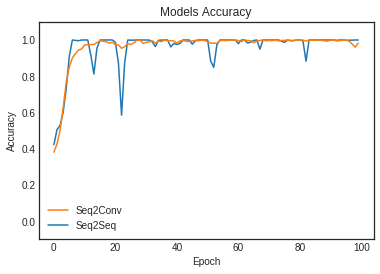

In [129]:
%pylab inline
plt.style.use('seaborn-white')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(-0.1,1.1,0.1)
s2s, = plt.plot(np.arange(len(ftt_s2s)), ftt_s2s, label='Seq2Seq')
s2c, = plt.plot(np.arange(len(ftt_s2c)), ftt_s2c, label='Seq2Conv')
plt.legend(handles=[s2c, s2s])
plt.title('Models Accuracy')
#plt.savefig("train_seq_accuracy.png")
plt.show()

Populating the interactive namespace from numpy and matplotlib


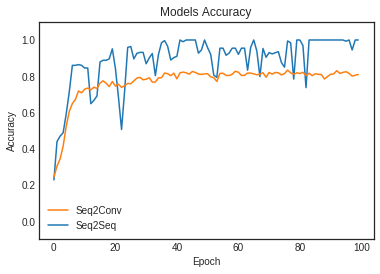

In [130]:
%pylab inline
plt.style.use('seaborn-white')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(-0.1,1.1,0.1)
s2s, = plt.plot(np.arange(len(ft_s2s)), ft_s2s, label='Seq2Seq')
s2c, = plt.plot(np.arange(len(ft_s2c)), ft_s2c, label='Seq2Conv')
plt.legend(handles=[s2c, s2s])
plt.title('Models Accuracy')
#plt.savefig("train_seq_accuracy.png")
plt.show()

Populating the interactive namespace from numpy and matplotlib


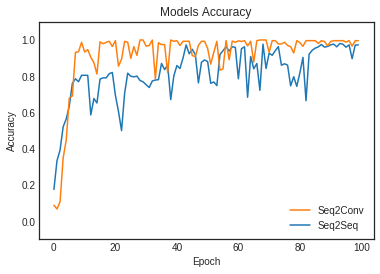

In [131]:
%pylab inline
plt.style.use('seaborn-white')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(-0.1,1.1,0.1)
s2s, = plt.plot(np.arange(len(ftv_s2s)), ftv_s2s, label='Seq2Seq')
s2c, = plt.plot(np.arange(len(ftv_s2c)), ftv_s2c, label='Seq2Conv')
plt.legend(handles=[s2c, s2s])
plt.title('Models Accuracy')
#plt.savefig("train_seq_accuracy.png")
plt.show()

In [2]:
files_human = glob.glob("./dataset/online_test/*.txt")
print(len(files_human))
for line in files_human:
    start = './dataset/online_test/'
    end = '.txt'
    fname = line[line.find(start)+len(start):line.rfind(end)]
    print('"' + fname + '"')

36
"remove_brown_2nd"
"cyan_4th"
"remove_cyan"
"cyan"
"remove_cyan_6th"
"remove_brown_4th"
"remove_6th"
"6th"
"remove_brown_odd"
"brown_every"
"brown_6th"
"brown"
"remove_odd"
"cyan_2nd"
"all"
"brown_4th"
"out"
"remove_2nd"
"remove_cyan_every"
"remove_cyan_odd"
"2nd"
"remove_brown_every"
"cyan_every"
"every"
"remove_brown"
"cyan_6th"
"remove_every"
"cyan_odd"
"4th"
"brown_odd"
"remove_cyan_4th"
"remove_cyan_2nd"
"remove_4th"
"brown_2nd"
"remove"
"remove_brown_6th"


In [68]:
import ast
result = []
list_files = glob.glob("./online-result/recover_words_seq2conv_trial2/recover_words_seq2conv_trial2/*.txt")
for file in list_files:
    for fh in files_human:
        start = './dataset/online_test/'
        end = '.txt'
        fname = fh[fh.find(start)+len(start):fh.rfind(end)]
        fname1 = "-data_" + fname + "-"
        fname2 = "-data_" + fname + "."
        if fname1 in file or fname2 in file:
#             print(file)
            with open(file, 'r') as f:
                for lf in f:
                    try:
                        res = ast.literal_eval(lf)
                        fname = fh[fh.find(start)+len(start):fh.rfind(end)]
                        result.append(fname + " " + str(res[1]))
                    except:
                        continue
for elem in sorted(result):
    #print(elem.split(" ")[0], elem.split(" ")[1])
    print(elem.split(" ")[1])
#     start = './dataset/online_test/'
#     end = '.txt'
#     fname = line[line.find(start)+len(start):line.rfind(end)]
#     print('"' + fname + '"')

0.9166666666666666
0.8888888888888888
1.0
0.7333333333333333
0.9666666666666667
0.9166666666666666
0.7619047619047619
0.9166666666666666
0.8095238095238095
0.9666666666666667
0.9047619047619048
0.875
0.8333333333333334
0.9259259259259259
0.8518518518518519
0.9523809523809523
0.7222222222222222
0.9666666666666667
0.8666666666666667
0.8055555555555556
0.8888888888888888
0.8611111111111112
0.8611111111111112
0.7948717948717948
0.8333333333333334
0.8611111111111112
0.8717948717948718
0.8717948717948718
0.8333333333333334
0.8809523809523809
0.8205128205128205
0.9230769230769231
0.9333333333333333
0.9333333333333333


In [6]:
import ast
result = 0
fname_res = ""
list_files = glob.glob("./online-result/hyperparameter_artificial_data_LSTM/k=1_unfreezed=1/*.txt")
for file in list_files:
    with open(file, 'r') as f:
        for lf in f:
            try:
                res = ast.literal_eval(lf)
                for r in res[:2]:
                    if result < r:
                        result = r
                        fname_res = file
            except:
                continue
print(result, fname_res)
#     start = './dataset/online_test/'
#     end = '.txt'
#     fname = line[line.find(start)+len(start):line.rfind(end)]
#     print('"' + fname + '"')

0.6666666666666666 ./online-result/hyperparameter_artificial_data_LSTM/k=1_unfreezed=1/output_hyperparameter_artificial_data_LSTM-regularize_0.0-steps_200-learner_gd-lr_0.001-data_lang_games_data_artificial_train_online_nvl-regularizeweights_0.0-optim_Adam-regularizeemb_0.0-lamb_0-k_1-unfreezed_7.txt


In [70]:
import ast
result = []
list_files = glob.glob("./online-result/recover_words_seq2conv_trial2/un7/un7/*.txt")
for file in list_files:
    for fh in files_human:
        start = './dataset/online_test/'
        end = '.txt'
        fname = fh[fh.find(start)+len(start):fh.rfind(end)]
        fname1 = "data_" + fname + "-"
        fname2 = "data_" + fname + "."
        if fname1 in file or fname2 in file:
#             print(file)
            with open(file, 'r') as f:
                for lf in f:
                    try:
                        res = ast.literal_eval(lf)
                        fname = fh[fh.find(start)+len(start):fh.rfind(end)]
                        result.append(fname + " " + str(res[1]))
                    except:
                        continue
for elem in sorted(result):
    print(elem.split(" ")[0], elem.split(" ")[1])
    #print(elem.split(" ")[1])
#     start = './dataset/online_test/'
#     end = '.txt'
#     fname = line[line.find(start)+len(start):line.rfind(end)]
#     print('"' + fname + '"')

2nd 1.0
4th 0.8333333333333334
6th 1.0
all 0.55
brown 0.9666666666666667
brown_2nd 0.9722222222222222
brown_4th 0.7142857142857143
brown_6th 0.875
brown_every 0.7142857142857143
brown_odd 0.9666666666666667
cyan 0.8571428571428571
cyan_2nd 0.8333333333333334
cyan_4th 0.7916666666666666
cyan_6th 0.9629629629629629
cyan_every 0.7777777777777778
cyan_odd 0.9047619047619048
every 0.9444444444444444
remove 0.9666666666666667
remove_2nd 0.9
remove_4th 0.8611111111111112
remove_6th 0.7777777777777778
remove_brown 0.9444444444444444
remove_brown_2nd 0.6666666666666666
remove_brown_2nd 0.8055555555555556
remove_brown_4th 0.717948717948718
remove_brown_6th 0.8333333333333334
remove_brown_every 0.8055555555555556
remove_brown_odd 0.8888888888888888
remove_cyan 0.8717948717948718
remove_cyan_2nd 0.8717948717948718
remove_cyan_4th 0.7619047619047619
remove_cyan_6th 0.7380952380952381
remove_cyan_every 0.9230769230769231
remove_cyan_odd 0.8974358974358975
remove_every 0.9333333333333333
remove_odd 0

In [72]:
import ast
result = []
list_files = glob.glob("./online-result/recover_words_seq2conv_trial2/k_1/*.txt")
for file in list_files:
    for fh in files_human:
        start = './dataset/online_test/'
        end = '.txt'
        fname = fh[fh.find(start)+len(start):fh.rfind(end)]
        fname1 = "data_" + fname + "-"
        fname2 = "data_" + fname + "."
        if fname1 in file or fname2 in file:
#             print(file)
            with open(file, 'r') as f:
                for lf in f:
                    try:
                        res = ast.literal_eval(lf)
                        fname = fh[fh.find(start)+len(start):fh.rfind(end)]
                        result.append(fname + " " + str(res[1]))
                    except:
                        continue
for elem in sorted(result):
    print(elem.split(" ")[1])
    #print(elem.split(" ")[1])
#     start = './dataset/online_test/'
#     end = '.txt'
#     fname = line[line.find(start)+len(start):line.rfind(end)]
#     print('"' + fname + '"')

0.9166666666666666
0.8333333333333334
0.8888888888888888
0.55
0.9666666666666667
0.8888888888888888
0.7142857142857143
0.875
0.7142857142857143
0.9666666666666667
0.8571428571428571
0.7916666666666666
0.8333333333333334
0.8518518518518519
0.5925925925925926
0.9523809523809523
0.6666666666666666
0.9
0.9
0.8611111111111112
0.8888888888888888
0.8333333333333334
0.75
0.7948717948717948
0.7619047619047619
0.8333333333333334
0.8611111111111112
0.9230769230769231
0.8461538461538461
0.7857142857142857
0.8809523809523809
0.7435897435897436
0.9230769230769231
0.8
0.9333333333333333


In [76]:
import ast
result = []
list_files = glob.glob("./online-result/recover_words_seq2conv_trial2/un5/*.txt")
for file in list_files:
    for fh in files_human:
        start = './dataset/online_test/'
        end = '.txt'
        fname = fh[fh.find(start)+len(start):fh.rfind(end)]
        fname1 = "data_" + fname + "-"
        fname2 = "data_" + fname + "."
        if fname1 in file or fname2 in file:
#             print(file)
            with open(file, 'r') as f:
                for lf in f:
                    try:
                        res = ast.literal_eval(lf)
                        fname = fh[fh.find(start)+len(start):fh.rfind(end)]
                        result.append(fname + " " + str(res[1]))
                    except:
                        continue
for elem in sorted(result):
    print(elem.split(" ")[1])
    #print(elem.split(" ")[1])
#     start = './dataset/online_test/'
#     end = '.txt'
#     fname = line[line.find(start)+len(start):line.rfind(end)]
#     print('"' + fname + '"')

0.5833333333333334
0.3888888888888889
0.4444444444444444
0.36666666666666664
0.6
0.5833333333333334
0.19047619047619047
0.2916666666666667
0.38095238095238093
0.6
0.23809523809523808
0.3333333333333333
0.3333333333333333
0.2962962962962963
0.25925925925925924
0.3333333333333333
0.4444444444444444
0.3333333333333333
0.36666666666666664
0.3055555555555556
0.4166666666666667
0.3055555555555556
0.3888888888888889
0.5
0.2564102564102564
0.2857142857142857
0.4166666666666667
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.38095238095238093
0.35714285714285715
0.358974358974359
0.38461538461538464
0.4
0.26666666666666666
